# MSDS 534: Statistical Learning - Homework 1

In this problem, we analyze the `Bikeshare` dataset (details [here](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)).

The `Bikeshare` data contains the hourly and daily count of rental bikes between years 2011 and 2012 in the Capital bikeshare system in Washington D.C., along with weather and seasonal information.

Our response data $\{y_i\}_{i=1}^n$ are the total number of bikers at each time period and our input data $\{\mathbf{x}_i=(x_{i1},\dots, x_{ip})\}_{i=1}^n$ consists of the features:
- hour of the day
- day of the year
- month of the year
- season (Winter, Spring, Summer, Fall)
- weekday (Sun, Mon, Tues, Wed, Thurs, Fri, Sat)
- holiday? (Yes=1, No=0)
- workday? (Yes=1, No=0)
- weather
- temperature (normalized, in Celcius)
- atemp (normalized feeling temperature, in Celcius)
- humidity
- windspeed

Before beginning this problem, download `bikeshare.csv` from Canvas (in `Files/homeworks/hw1`). Save `bikeshare.csv` in the same directory (folder) as this Jupyter notebook.

The following cell loads the packages you need for this problem and loads the `Bikeshare` data.

The cell also splits the data into train and test data, stored as `numpy` objects:
- `x_train_np` 
- `y_train_np`
- `x_test_np` 
- `y_test_np`

In this problem, we will compare different models for predicting $Y_i$ from $\mathbf{x}_i$. Complete the questions and fill in the code where it states `[INSERT CODE]`. To grade your homeworks, we will run your completed Jupyter notebook and grade the output.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import random
random.seed(10)
torch.manual_seed(10)

bike_data = pd.read_csv('bikeshare.csv')
y = bike_data['bikers']
x = bike_data.iloc[:, 1:]

n = bike_data.shape[0]

# get training and test indicies
inds = np.random.binomial(1, 0.8, size=n)
n_train = sum(inds)
n_test = len(inds)-sum(inds)

# turn pandas df to numpy
x_np = x.to_numpy()
y_np = y.to_numpy()

x_np = x_np.astype(np.float32)
y_np = y_np.astype(np.float32)

# separate into train/test data
x_train_np = x_np[inds==1, :]
y_train_np = y_np[inds==1]
x_test_np = x_np[inds==0, :]
y_test_np = y_np[inds==0]

### Part 1: Poisson regression

We first use a generalized linear model to fit our data. As our response is count data (i.e. number of bikes), we use a Poisson regression model:
$$Y_i \sim \text{Poisson}(\exp(\mathbf{x}_i^T\boldsymbol{\beta})), \quad \boldsymbol{\beta}\in\mathbb{R}^p, i = 1,\dots, n.$$

_Q1: Fit this Poisson regression model to `x_train_np` and `y_train_np` using `sklearn.linear_model.PoissonRegressor()`. Using the fitted model, get predictions from `x_test_np`. Print the mean squared error between predicted responses and `y_test_np`._

In [5]:
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error

model = PoissonRegressor()
model.fit(x_train_np, y_train_np)

y_pred = model.predict(x_test_np)

mse = mean_squared_error(y_test_np, y_pred)
mse

4873.3567352231985

_Q2: For the test data, plot predicted responses (y-axis) vs actual responses (x-axis). Your plot look similar to:_

![this](poisson_linear.png)

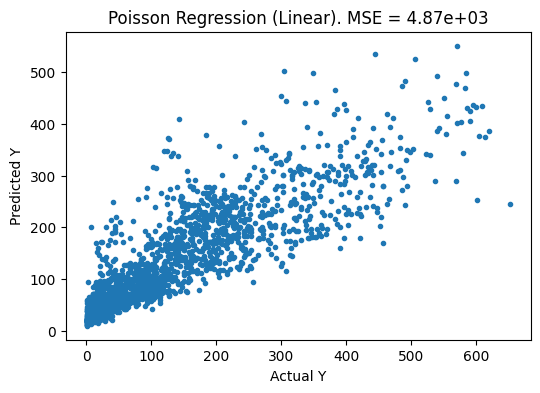

In [7]:
mse_display = np.format_float_scientific(mse, precision=2,trim='k')
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4)
ax.plot(y_test_np, y_pred, '.', label="observed")
ax.set_title('Poisson Regression (Linear). MSE = ' + str(mse_display))
ax.set_xlabel('Actual Y')
ax.set_ylabel('Predicted Y')
plt.savefig('poisson_linear.png')

## Part 2: Poisson regression using neural networks

Let's now try Poisson regression, but with a neural network link function. The model is:

$$Y_i \sim \text{Poisson}(\exp(f(\mathbf{x}_i, \boldsymbol{\theta})))$$
where $f$ is a neural network and $\boldsymbol{\theta}$ are the weights and biases of the network.

_Q1: Convert `x_train_np, y_train_np, x_test_np, y_test_np` to `torch` tensors._

In [8]:
# convert numpy to torch tensors
x_train = torch.from_numpy(x_train_np)
y_train = torch.from_numpy(y_train_np)
x_test = torch.from_numpy(x_test_np)
y_test = torch.from_numpy(y_test_np)

y_train = y_train[:, None]  # make n_train x 1 matrix (this is helpful for future calculations)
y_test = y_test[:, None]

_Q2: Create a `TensorDataset` called `train_data` from the training data. Create a `DataLoader` called `train_loader` for this `train_data`. Set `batch_size=10` and `shuffle=True`._

In [9]:
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

_Q3: Create a neural network class called `PoissonNet` by completing in the following code. Note: the probability mass function for $Y_i$ is:_
$$P(Y_i=y_i|f_{\theta}(\mathbf{x}_i)) = \frac{\exp(y_if_{\theta}(\mathbf{x}_i))\exp(-e^{f_{\theta}(\mathbf{x}_i)})}{y_i!}.$$

In [10]:
# define the neural network
class PoissonNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(PoissonNet, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

     # create a neural network with below hidden node dimensions and ReLU activations
        # hidden_dim = [100, 100, 50]
        
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc_out = nn.Linear(50, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = torch.exp(self.fc_out(x))
        return out

    def loss_fn(self, x, y):
        
        # write a loss function for the Poisson model above
        lam = self.forward(x)
        out = torch.mean(lam - y * torch.log(lam + 1e-8))  

        return out

_Q4: Fit `PoissonNet` to the training data by completing the following code._

In [11]:
# instantiate model
input_dim = x_train.shape[1]   
output_dim = 1                 
model = PoissonNet(input_dim=input_dim, output_dim=output_dim)

lr = 0.001
epochs = 100

# create optimizer with Adam
optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):
    epoch_loss = 0

    # iterate over mini-batches of the data
    for xb, yb in train_loader:

        # compute the loss for current mini-batch
        loss = model.loss_fn(xb, yb)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{epoch_loss:.3}")

epoch:  0 loss: -4.03e+05
epoch:  10 loss: -4.36e+05
epoch:  20 loss: -4.36e+05
epoch:  30 loss: -4.37e+05
epoch:  40 loss: -4.37e+05
epoch:  50 loss: -4.37e+05
epoch:  60 loss: -4.37e+05
epoch:  70 loss: -4.37e+05
epoch:  80 loss: -4.37e+05
epoch:  90 loss: -4.37e+05


_Q5: For the test data, plot predicted responses (y-axis) vs actual responses (x-axis). Your plot look similar to the below image. What do you notice compared to the results from Part 1?_

![this](poisson_neural.png)

Text(0, 0.5, 'Predicted Y')

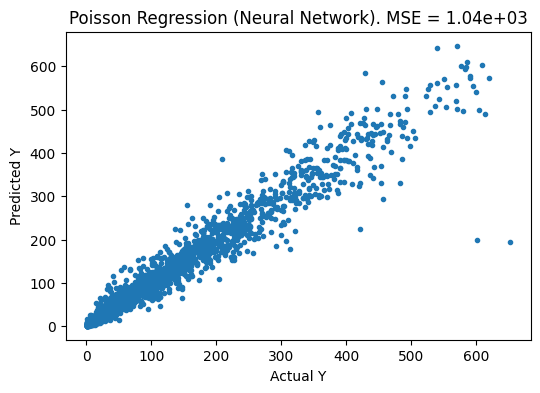

In [12]:
# get predictions from model 
y_pred = model(x_test)

# convert y_pred back to numpy and flatten
y_pred_np = torch.flatten(y_pred).detach().numpy()

mse = mean_squared_error(y_test_np, y_pred_np)

mse_display = np.format_float_scientific(mse, precision=2, trim='k')

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4)

ax.plot(y_test_np, y_pred_np, '.', label="observed")

ax.set_title('Poisson Regression (Neural Network). MSE = ' + str(mse_display))
ax.set_xlabel('Actual Y')
ax.set_ylabel('Predicted Y')

#Compared to the results from Part 1,predictions align much more closely with the 45° line. 
#The scatter is tighter, meaning neural network captures nonlinear relationships better. MSE also drops significantly.

## Part 3: Negative binomial regression using neural networks

For the Poisson distribution, the mean = the variance. This may not be a good assumption. A more flexible count model for $Y_i$ is the negative binomial distribution. In this section, we fit a negative binomial neural network model to the data.

_Q1: Create a neural network class called `NBNet` by completing the following code._

Note that the negative binomial probability mass function is:
$$P(Y_i=y_i) = \frac{\Gamma(y_i + r(\mathbf{x}_i,\boldsymbol{\theta}))}{y_i!\Gamma(r(\mathbf{x_i},\boldsymbol{\theta}))}[1-p(\mathbf{x}_i,\boldsymbol{\theta})]^{y_i} [p(\mathbf{x}_i,\boldsymbol{\theta})]^{r(\mathbf{x_i},\boldsymbol{\theta})}.$$

We also have $$\mathbb{E}[Y_i|\mathbf{x}_i] = \frac{r(\mathbf{x}_i,\boldsymbol{\theta})[1- p(\mathbf{x}_i,\boldsymbol{\theta})]}{p(\mathbf{x}_i,\boldsymbol{\theta})}.$$

Helpful `torch` functions:
- `torch.lgamma`: computes log of $\Gamma$ function

In [13]:
class NBNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(NBNet, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        hidden_dim = [100, 100]
        r_dim = [50]
        p_dim = [50]

        # create backbone
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for i in range(len(hidden_dim)):                
            hdim = hidden_dim[i]                     
            self.layers.append(nn.Linear(current_dim, hdim))  
            current_dim = hdim                         

        # create r head
        core_dim = hidden_dim[-1]
        current_dim = core_dim
        self.r_layers = nn.ModuleList()
        for i in range(len(r_dim)):
            hdim = r_dim[i]                        
            self.r_layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim                        
        self.r_layers.append(nn.Linear(current_dim, self.output_dim)) 

        # create p head 
        current_dim = core_dim
        self.p_layers = nn.ModuleList()
        for i in range(len(p_dim)):                    
            hdim = p_dim[i]                            
            self.p_layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim                      
        self.p_layers.append(nn.Linear(current_dim, self.output_dim))

    def core_net(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return x

    def r_net(self, x):
        for layer in self.r_layers[:-1]:
            x = F.relu(layer(x))                         
        out = torch.exp(self.r_layers[-1](x))     ## r needs to be > 0      
        return out

    def p_net(self, x):
        for layer in self.p_layers[:-1]:
            x = F.relu(layer(x))                         
        out = F.sigmoid(self.p_layers[-1](x))     ## p needs to be [0,1]     
        return out

    def forward(self, x):
        core = self.core_net(x)
        r = self.r_net(core)                             
        p = self.p_net(core)                            
        return r, p

    def loss_fn(self, x, y):
        r, p = self.forward(x)

        eps = 1e-8
        log_pmf = (
            torch.lgamma(y + r) - torch.lgamma(r) - torch.lgamma(y + 1.0)
            + r * torch.log(1.0 - p + eps)
            + y * torch.log(p + eps)
        )
        out = -torch.mean(log_pmf)                       
        return out

_Q2: Fit `NBNet` to the data by completing the following code._

In [14]:
# instantiate NBNet
input_dim = x_train.shape[1]
output_dim = 1

model = NBNet(input_dim=input_dim, output_dim=output_dim)

lr = 0.001
epochs = 100

# create optimizer with Adam
optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):
    epoch_loss = 0

    # iterate over mini-batches of the data
    for xb, yb in train_loader:

        # compute the loss for current mini-batch
        loss = model.loss_fn(xb, yb)
        
        # take gradient
        loss.backward()
        # update parameters
        optimizer.step()
        # reset gradients to zero
        optimizer.zero_grad()

        epoch_loss += loss.item()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{epoch_loss:.3}")

epoch:  0 loss: 5.48e+03
epoch:  10 loss: 2.85e+03
epoch:  20 loss: 2.61e+03
epoch:  30 loss: 2.47e+03
epoch:  40 loss: 2.37e+03
epoch:  50 loss: 2.35e+03
epoch:  60 loss: 2.3e+03
epoch:  70 loss: 2.28e+03
epoch:  80 loss: 2.26e+03
epoch:  90 loss: 2.24e+03


_Q3: Plot predicted responses (y-axis) vs actual responses (x-axis). Your plot look similar to the below image. What do you notice compared to the results from Parts 1 and 2?_

![this](neg_binom.png)

Text(0, 0.5, 'Predicted Y')

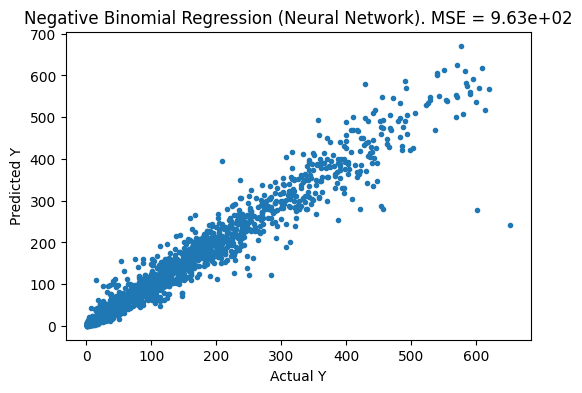

In [15]:
# get predictions from model 
r, p = model(x_test)
y_pred = r * p / (1 - p + 1e-8)   # NB mean

# convert y_pred back to numpy and flatten
y_pred_np = torch.flatten(y_pred).detach().numpy()

mse = mean_squared_error(y_test_np, y_pred_np)

mse_display = np.format_float_scientific(mse, precision=2, trim='k')

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 4)

# scatter plot: actual vs predicted
ax.plot(y_test_np, y_pred_np, '.', label="observed")

ax.set_title('Negative Binomial Regression (Neural Network). MSE = ' + str(mse_display))
ax.set_xlabel('Actual Y')
ax.set_ylabel('Predicted Y')

#When compared to the other 2 plots, in this one, the points are closer to the 45° line and spread is reduced. MSE drops further. 
#Negative Binomial handles overdispersion so it models the bike counts more realistically than Poisson, giving the best predictive accuracy.